## Imports

In [47]:
#Must Haves
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import datetime

#Data Processing and Stats!
import pandas as pd
import numpy as np

#Regex
import re

#For Image Plots
import matplotlib.image as im
%matplotlib inline
import matplotlib.pyplot as plt

#File Org
import glob
import os
import sys

## Selenium! 

https://www.selenium.dev/selenium/docs/api/py/


### Browser Drivers:

https://chromedriver.chromium.org/downloads

https://github.com/mozilla/geckodriver

### Launch!

In [4]:
geckoDriverPath = '/Users/matthewmitchell/Documents/Projects/Tools/Python/Scraping/geckodriver'
driver = webdriver.Firefox(executable_path=geckoDriverPath)

In [ ]:
driver.get("https://webcams.nyctmc.org/cameras-list")

## XPath Selections Are Your Friend!

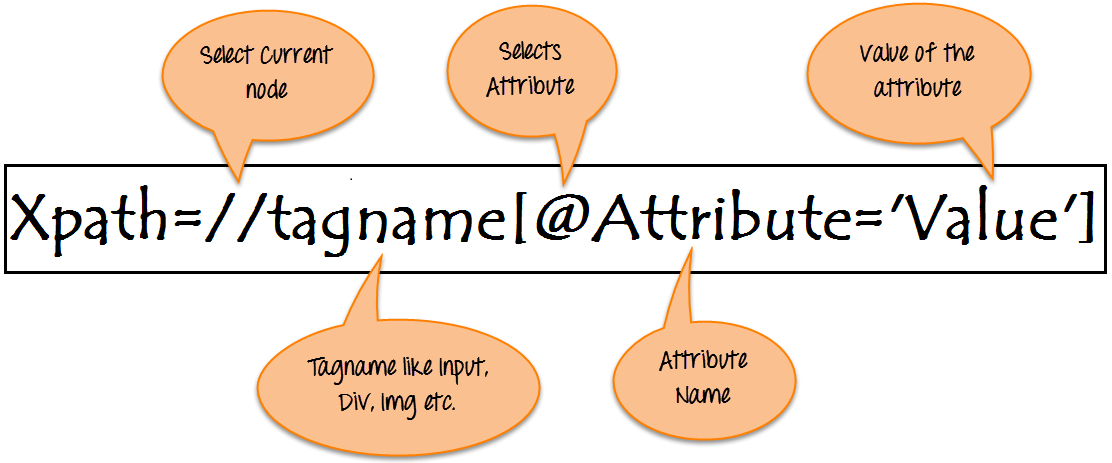

## Main Components and Scrape Address Table

In [102]:
def get_address_borough(trow):
    cb_cell, a_cell, b_cell =  trow.find_elements_by_tag_name('td')[:3]
    return (cb_cell, a_cell.text, b_cell.text)

In [103]:
def parse_row_text(row_text):
    boroughs = ['Manhattan','Bronx','Staten Island','Queens','Brooklyn']
    borough = [b for b in boroughs if b in row_text][0]
    address = row_text.replace(borough,"")
    return address, borough

In [173]:
body = driver.find_element_by_tag_name('body')
body = body.find_element_by_tag_name('body')
main_div = body.find_element_by_tag_name('div')

app_nav = main_div.find_element_by_tag_name('app-navigation')

cam_list_pc = main_div.find_element_by_xpath("//div[@class='g-view-wrapper g-flex ng-tns-c113-0']")
# app_cam_list = div2.find_element_by_tag_name('app-camera-list')
cam_list_pc.get_attribute('class') #g-view-wrapper g-flex ng-tns-c113-0
cam_list = cam_list_pc.find_element_by_tag_name('app-cameras-list')
tbody = cam_list.find_element_by_tag_name('tbody')
trows = tbody.find_elements_by_tag_name('tr')

table_addresses = []
for trow in trows:
    cb_cell , a , b = get_address_borough(trow)
    table_addresses.append((a,b))
#Format as DataFrame (like excel spreadsheet)
df = pd.DataFrame(table_addresses)
df.columns = ['Address','Borough']
df.head()

,Address,Borough
0,1 Ave @ 110 St,Manhattan
1,1 Ave @ 124 St,Manhattan
2,1 Ave @ 14 St,Manhattan
3,1 Ave @ 23 St,Manhattan
4,1 ave @ 40 st,Manhattan


### dev scratcphad - iterate through table

In [43]:
trow = trows[0]
cb_cell, a_cell, b_cell =  trow.find_elements_by_tag_name('td')[:3]
print(a_cell.text)
print(b_cell.text)
checkbox = cb_cell.find_element_by_tag_name('mat-checkbox')
#     print(td.text, "\n")

1 Ave @ 110 St
Manhattan


### Click Checkbox

In [44]:
checkbox = cb_cell.find_element_by_tag_name('mat-checkbox')
checkbox.click()

## Click Several Checkboxes

#### Number of Checkboxes (with a starting point)

In [174]:
start = 0
n_to_check = 9
for i, trow in enumerate(trows):
    cb_cell , a , b = get_address_borough(trow)
    if i in range(start, n_to_check):
        checkbox = cb_cell.find_element_by_tag_name('mat-checkbox')
        checkbox.click()
    

#### By Address (Random Sample)

In [156]:
addresses = list(df.sample(9).Address)
# print("Addresses: ", addresses)
for i, trow in enumerate(trows):
    cb_cell , a , b = get_address_borough(trow)
    if a in addresses:
        print("Selecting: {}".format(a))
        checkbox = cb_cell.find_element_by_tag_name('mat-checkbox')
        checkbox.click()

Selecting: 1 Ave @ 14 St
Selecting: 1 ave @ 40 st
Selecting: 1 Ave @ 96 St
Selecting: 1 Ave @ E 14 St
Selecting: 1 Ave @ E. Houston St
Selecting: 1 Avenue @ East 60 Street
Selecting: 11 Ave @ 34 ST
Selecting: 11 Ave @ 42 St
Selecting: 11 Ave @ 57 St


## Unclick Checkbox

In [172]:
driver.refresh()

In [157]:
# for i, trow in enumerate(trows):
#     cb_cell , a , b = get_address_borough(trow)
#     checkbox = cb_cell.find_element_by_tag_name('mat-checkbox')
#     if checkbox.get_attribute('aria-checked'):
#         print('{} Checked!'.format(a))
#         checkbox.click()
#JUST REFRESH and Reload Driver Element Selections!!!

## View Selected Cameras

### Click "View Selected"

In [175]:
button = cam_list.find_element_by_tag_name('button')
button.click()

## Get Camera Image(s)

In [215]:
def clean_img_address(a):
    a = a.replace(" ","_")
    a = a.replace("@","at")
    a = a.replace("/","_")
    a = a.replace(".","")
    return a

In [191]:
def img_add_folder(img_address):
    folder = clean_img_address(img_address)
    if os.path.exists(folder):
        os.chdir(folder)
    else:
        os.mkdir(folder)
        os.chdir(folder)

In [193]:
def save_image(selenium_img_obj, to_print=False):
    time_now = datetime.datetime.now().strftime("%m-%d-%Y_%H%M_%S")
    img_filename = "{}_{}.png".format(folder, time_now)
    if to_print:
        print("Saving to: ", img_filename)
    #Save
    selenium_img_obj.screenshot(img_filename)

In [200]:
proj_dir = os.getcwd()
proj_dir

'/Users/matthewmitchell/Documents/ITP_Camp/NYC511_CameraScrape/images'

In [194]:
def scrape_images(driver, proj_dir):
    #Get Camera Preview Element
    cam_preview = driver.find_element_by_tag_name('app-dialog-camera-preview')
    #Get Grid
    cam_grid = cam_preview.find_element_by_class_name('cameras-grid')
    cam_previews = cam_grid.find_elements_by_tag_name('app-camera-view')
    for cam_n_preview in cam_previews:
        #Print address
        img_address = cam_n_preview.text.split("\n")[0]
        print(img_address)
        imgs = cam_n_preview.find_elements_by_tag_name('img')
        cam_img = [i for i in imgs if 'watermark' not in i.get_attribute('class')][0]
        #Folder Structure
        img_add_folder(img_address)
        #Save
        save_image(cam_img, to_print=True)
        #Return to Root Folder
        os.chdir(proj_dir)

In [195]:
scrape_images(driver, proj_dir)

1 Ave @ 110 St
Saving to:  1_Ave_at_110_St_06-24-2023_1757_28.png
1 Ave @ 124 St
Saving to:  1_Ave_at_110_St_06-24-2023_1757_28.png
1 Ave @ 14 St
Saving to:  1_Ave_at_110_St_06-24-2023_1757_28.png
1 Ave @ 23 St
Saving to:  1_Ave_at_110_St_06-24-2023_1757_29.png
1 ave @ 40 st
Saving to:  1_Ave_at_110_St_06-24-2023_1757_29.png
1 Ave @ 42 St
Saving to:  1_Ave_at_110_St_06-24-2023_1757_29.png
1 Ave @ 57 st
Saving to:  1_Ave_at_110_St_06-24-2023_1757_29.png
1 Ave @ 59 St
Saving to:  1_Ave_at_110_St_06-24-2023_1757_29.png
1 Ave @ 62 St
Saving to:  1_Ave_at_110_St_06-24-2023_1757_30.png


In [202]:
pwd

'/Users/matthewmitchell/Documents/ITP_Camp/NYC511_CameraScrape/images'

## Final Loop

In [212]:
driver.close()

In [213]:
driver = webdriver.Firefox(executable_path=geckoDriverPath)
time.sleep(5)
driver.get("https://webcams.nyctmc.org/cameras-list")

In [214]:
dfs = []
last_row_scraped = 0
for scrape_set in range(10):
    driver.refresh()
    time.sleep(3)
    #Get Element Selections
    body = driver.find_element_by_tag_name('body')
    body = body.find_element_by_tag_name('body')
    main_div = body.find_element_by_tag_name('div')

    app_nav = main_div.find_element_by_tag_name('app-navigation')

    cam_list_pc = main_div.find_element_by_xpath("//div[@class='g-view-wrapper g-flex ng-tns-c113-0']")
    # app_cam_list = div2.find_element_by_tag_name('app-camera-list')
    cam_list_pc.get_attribute('class') #g-view-wrapper g-flex ng-tns-c113-0
    cam_list = cam_list_pc.find_element_by_tag_name('app-cameras-list')
    tbody = cam_list.find_element_by_tag_name('tbody')
    trows = tbody.find_elements_by_tag_name('tr')

    table_addresses = []
    for trow in trows:
        cb_cell , a , b = get_address_borough(trow)
        table_addresses.append((a,b))
    #Format as DataFrame (like excel spreadsheet)
    df = pd.DataFrame(table_addresses)
    df.columns = ['Address','Borough']


    start = last_row_scraped
    n_to_check = 9
    for i, trow in enumerate(trows):
        cb_cell , a , b = get_address_borough(trow)
        if i in range(start, start+n_to_check):
            checkbox = cb_cell.find_element_by_tag_name('mat-checkbox')
            checkbox.click()
            last_row_scraped += 1
    time.sleep(1.5)
    
    button = cam_list.find_element_by_tag_name('button')
    button.click()
    
    time.sleep(2)
    scrape_images(driver, proj_dir)
    time.sleep(20)

1 Ave @ 110 St
Saving to:  1_Ave_at_110_St_06-24-2023_1815_58.png
1 Ave @ 124 St
Saving to:  1_Ave_at_110_St_06-24-2023_1815_58.png
1 Ave @ 14 St
Saving to:  1_Ave_at_110_St_06-24-2023_1815_58.png
1 Ave @ 23 St
Saving to:  1_Ave_at_110_St_06-24-2023_1815_58.png
1 ave @ 40 st
Saving to:  1_Ave_at_110_St_06-24-2023_1815_59.png
1 Ave @ 42 St
Saving to:  1_Ave_at_110_St_06-24-2023_1815_59.png
1 Ave @ 57 st
Saving to:  1_Ave_at_110_St_06-24-2023_1815_59.png
1 Ave @ 59 St
Saving to:  1_Ave_at_110_St_06-24-2023_1815_59.png
1 Ave @ 62 St
Saving to:  1_Ave_at_110_St_06-24-2023_1815_59.png
1 Ave @ 86 St
Saving to:  1_Ave_at_110_St_06-24-2023_1816_31.png
1 Ave @ 96 St
Saving to:  1_Ave_at_110_St_06-24-2023_1816_32.png
1 Ave @ E 14 St
Saving to:  1_Ave_at_110_St_06-24-2023_1816_32.png
1 Ave @ E. Houston St
Saving to:  1_Ave_at_110_St_06-24-2023_1816_32.png
1 Avenue @ East 60 Street
Saving to:  1_Ave_at_110_St_06-24-2023_1816_32.png
1 st Camera South Bound BPU-148.55
Saving to:  1_Ave_at_110_St_06-

FileNotFoundError: [Errno 2] No such file or directory: '11_Ave/Rt_9A_at_14_St'

In [206]:
start

9

In [210]:
n_to_check

9

In [211]:
range(9,9)

range(9, 9)

In [207]:
last_row_scraped

9

In [209]:
len(trows)

25

In [208]:
for i, trow in enumerate(trows):
    cb_cell , a , b = get_address_borough(trow)
    if i in range(start, start+n_to_check):
        print("Should be checking this row!! {}".format(a, b))

## Dev Camera Scratchpad.

In [177]:
cam_preview = driver.find_element_by_tag_name('app-dialog-camera-preview')
# cam_img = cam_preview.find_element_by_tag_name('img')

In [178]:
cam_grid = cam_preview.find_element_by_class_name('cameras-grid')

In [179]:
cam_previews = cam_grid.find_elements_by_tag_name('app-camera-view')
print(len(cam_previews))

9


In [180]:
cam_n_preview = cam_previews[0]

In [181]:
imgs = cam_n_preview.find_elements_by_tag_name('img')
print(len(imgs))

2


In [166]:
cam_img = [i for i in imgs if 'watermark' not in i.get_attribute('class')][0]
# print(len(cam_imgs))

In [167]:
img_address = cam_n_preview.text.split("\n")[0]
print(img_address)

1 Ave @ 14 St


In [77]:
ls

Intro_to_Scraping_With_Python.ipynb  camScraper.py
README.md                            geckodriver.log


In [78]:
proj_dir = os.getcwd()

True

In [84]:
folder = clean_img_address(img_address)
if os.path.exists(folder):
    os.chdir(folder)
else:
    os.mkdir(folder)
    os.chdir(folder)
print("Cur Dir: ", os.getcwd())

Cur Dir:  /Users/matthewmitchell/Documents/ITP_Camp/NYC511_CameraScrape/1_Ave_at_110_St


In [92]:
pwd

'/Users/matthewmitchell/Documents/ITP_Camp/NYC511_CameraScrape/1_Ave_at_110_St'

In [98]:
for i in range(10):
    time_now = datetime.datetime.now().strftime("%m-%d-%Y_%H%M_%S")
    img_filename = "{}_{}.png".format(folder, time_now)
    print("Saving to: ", img_filename)
    
    #Save
    cam_img.screenshot(img_filename)
    time.sleep(2)
    #Preview
#     img = im.imread(img_filename)
#     plt.figure()
#     plt.imshow(img)

Saving to:  1_Ave_at_110_St_06-24-2023_1607_21.png
Saving to:  1_Ave_at_110_St_06-24-2023_1607_23.png
Saving to:  1_Ave_at_110_St_06-24-2023_1607_25.png
Saving to:  1_Ave_at_110_St_06-24-2023_1607_27.png
Saving to:  1_Ave_at_110_St_06-24-2023_1607_30.png
Saving to:  1_Ave_at_110_St_06-24-2023_1607_32.png
Saving to:  1_Ave_at_110_St_06-24-2023_1607_34.png
Saving to:  1_Ave_at_110_St_06-24-2023_1607_36.png
Saving to:  1_Ave_at_110_St_06-24-2023_1607_39.png
Saving to:  1_Ave_at_110_St_06-24-2023_1607_41.png


In [93]:
time_now = datetime.datetime.now().strftime("%m-%d-%Y_%H%M_%S")
img_filename = "{}_{}.png".format(folder, time_now)
print(img_filename)

1_Ave_at_110_St_06-24-2023_1605_01.png


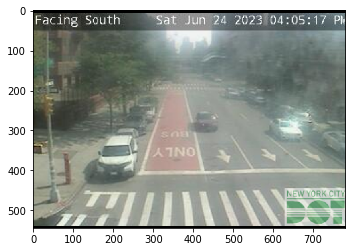

In [96]:
cam_img.screenshot(img_filename)
img = im.imread(img_filename)
plt.figure()
plt.imshow(img)

## Dev Scratchpad

In [27]:
sub_divs = main_div.find_elements_by_tag_name('div')
print(len(sub_divs))

67


In [29]:
for sub_div in sub_divs[:5]:
    print(sub_div.get_attribute('class'))

g-view-container g-flex-column
nav-overlay ng-tns-c113-0 ng-star-inserted
g-view-wrapper g-flex ng-tns-c113-0
g-view-container g-flex-column ng-tns-c103-1 ng-trigger ng-trigger-fadeAnimation
g-flex-row g-view-toolbar mdc-elevation--z3 ng-tns-c103-1


In [25]:
print("Class: {}".format(main_div.get_attribute('class')))
print("Tag type: {}".format(main_div.tag_name))

Class: g-view-wrapper g-flex g-flex-row ng-tns-c113-0
Tag type: div
